In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
from scipy import stats
import torch

We will first mount the Google Collab to Drive and upload the files


In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os


In [5]:
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Neural Computing/Group Coursework'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['heart_data.csv', 'Group Coursework Python.ipynb', ' Group Coursework Python.ipynb']


In [6]:
data = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH,'heart_data.csv'))

We will check for the descrpitves of the first few rows, look at the data types in our dataset and check if there are any missing variables in the DataSet.

In [ ]:
data.head()
print(data)

In [8]:
data.isnull().sum()

rest_bp            0
chest_pain         0
thalassemia        0
age                0
fasting_bs         0
max_hr             0
exercise_angina    0
gender             0
st_slope           0
cholesterol        0
st_depression      0
rest_ecg           0
num_vessels        0
diagnosis          0
dtype: int64

In [ ]:
data.dtypes

We will now describe the target variable and plot boxplots with it

(array([160.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 137.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

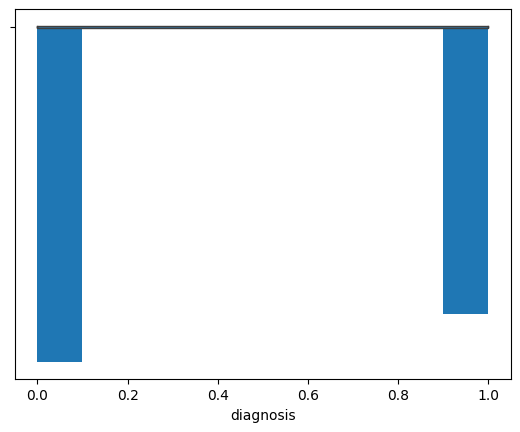

In [12]:
data['diagnosis'].describe()

sns.boxplot(data = data, x = 'diagnosis')

plt.hist(data['diagnosis'])

We will separate the dataset into numeric and categrical features so we can better visualize them

In [11]:
numeric_features = ['age', 'cholesterol', 'max_hr', 'st_depression', 'diagnosis']

cat_features = ['gender', 'chest_pain', 'fasting_bs', 'rest_ecg', 'exercise_angina', 'st_slope', 'num_vessels', 'thalassemia']

print("Numeric features:", numeric_features)
print("Categorical features:", cat_features)

Numeric features: ['age', 'cholesterol', 'max_hr', 'st_depression', 'diagnosis']
Categorical features: ['gender', 'chest_pain', 'fasting_bs', 'rest_ecg', 'exercise_angina', 'st_slope', 'num_vessels', 'thalassemia']


In [13]:
data_numeric = data[numeric_features]

data_cat = data[cat_features]

We will make a heatmap with the numerical values so we can observe which features are more relevant to the target variable, the diagnosis.

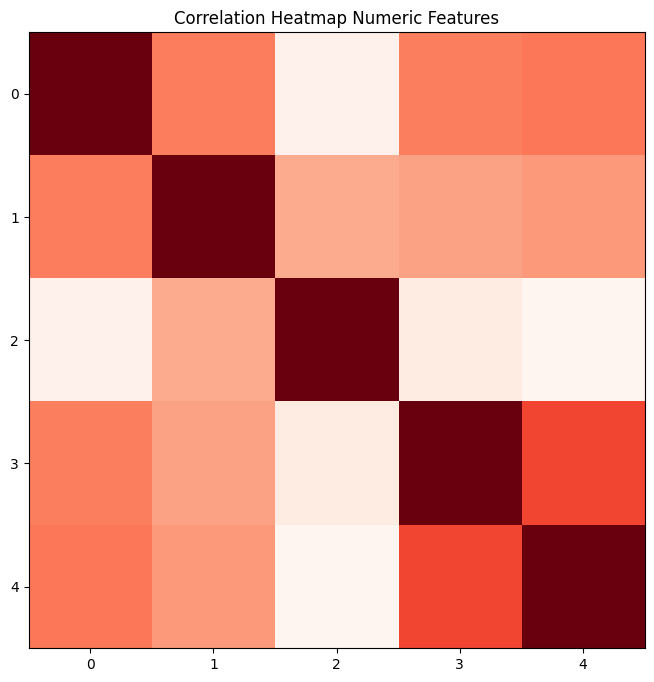

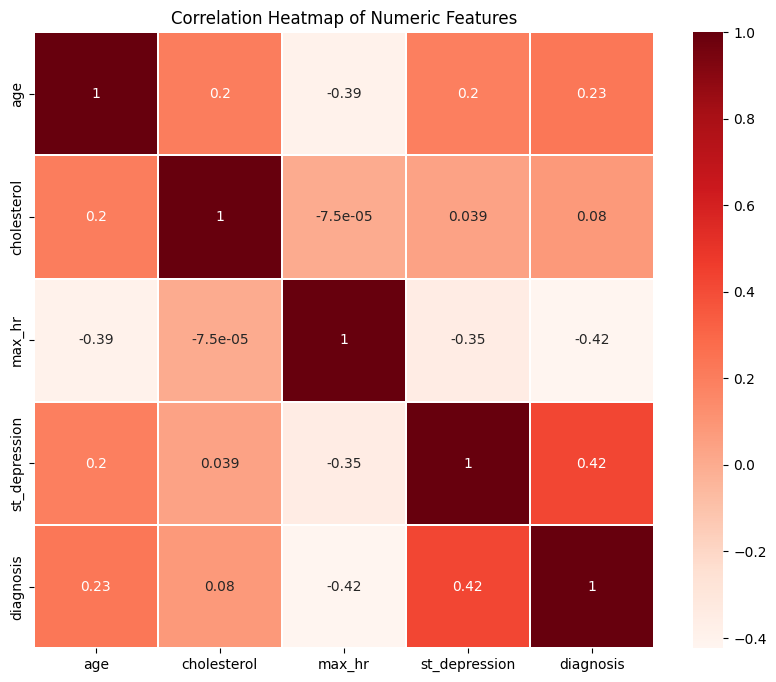

In [14]:
corr_data_numeric = data_numeric.corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr_data_numeric, cmap ='Reds')
plt.title('Correlation Heatmap Numeric Features')
plt.show()

#Using sns:

plt.figure(figsize=(10, 8))
sns.heatmap(corr_data_numeric, annot=True, cmap='Reds', linewidths=0.1)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


We will now draw boxplots, histograms and QQ plots for all the numerical variables in the Dataset so we can check for normal Distribution and better understand the Dataset.

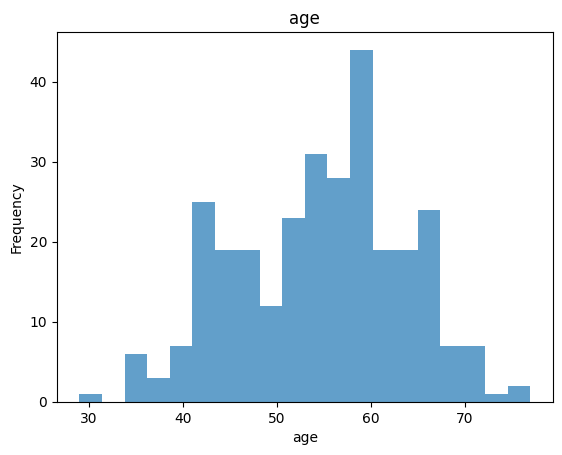

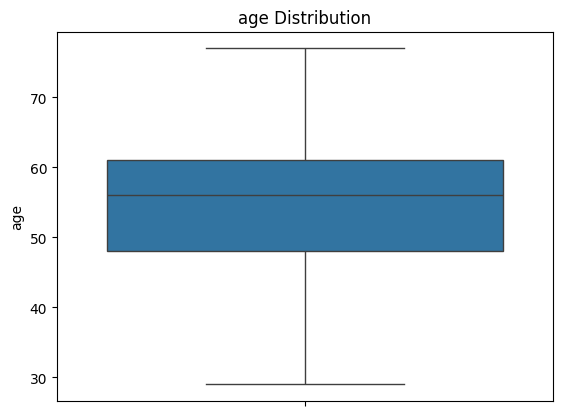

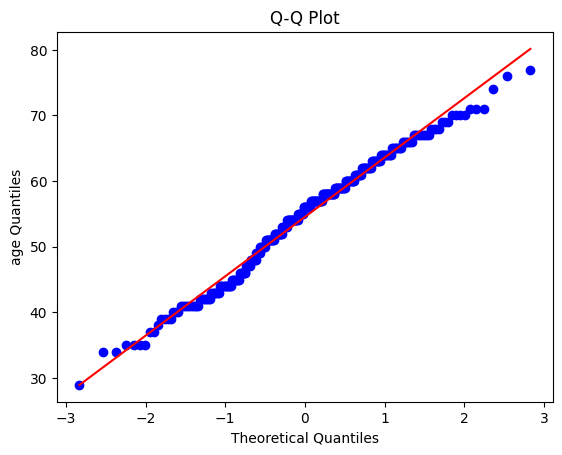

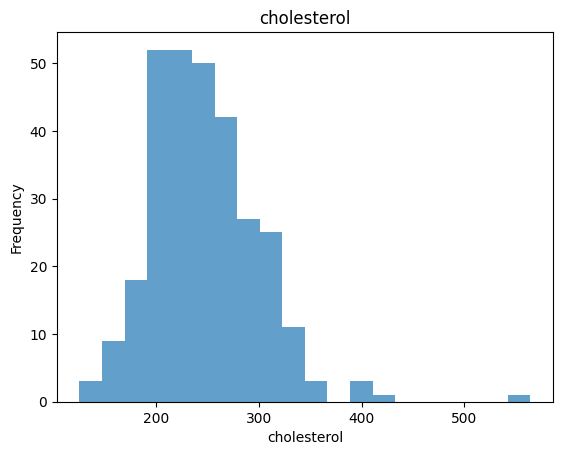

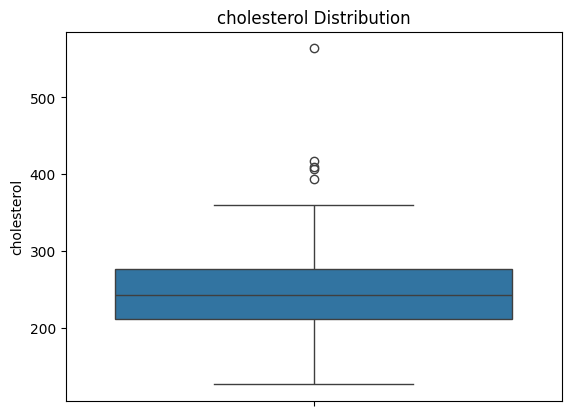

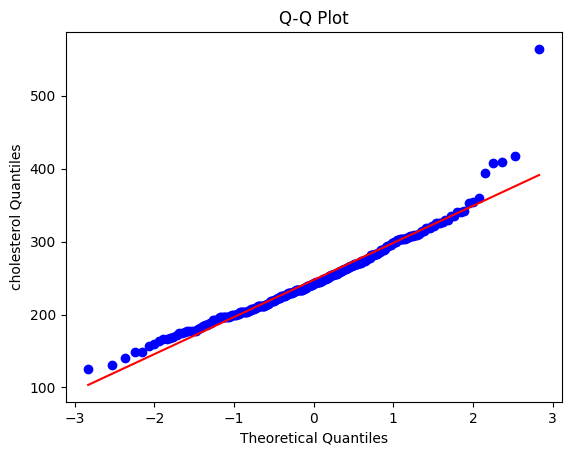

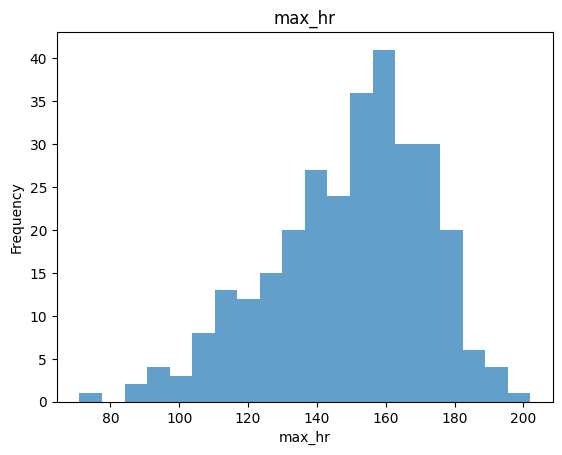

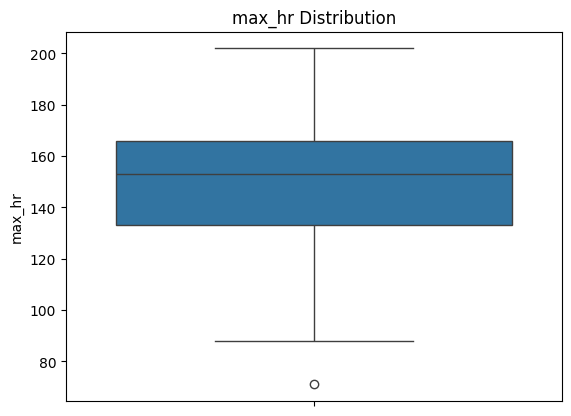

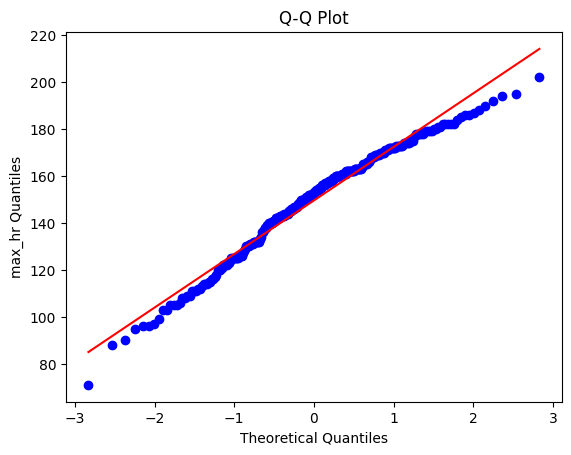

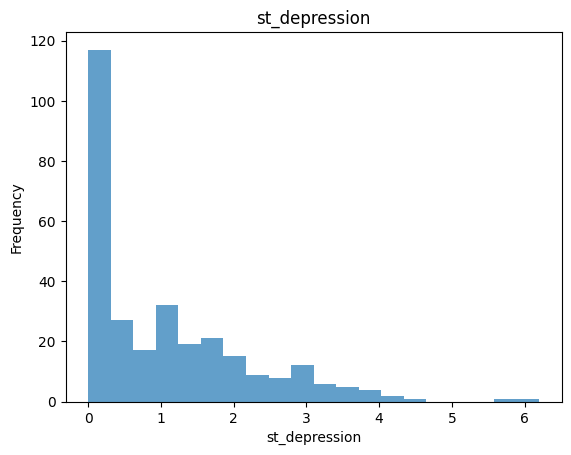

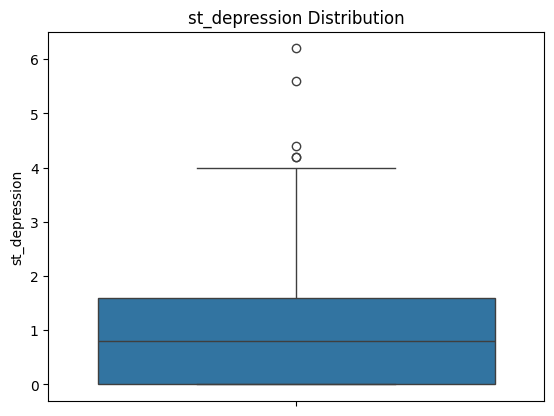

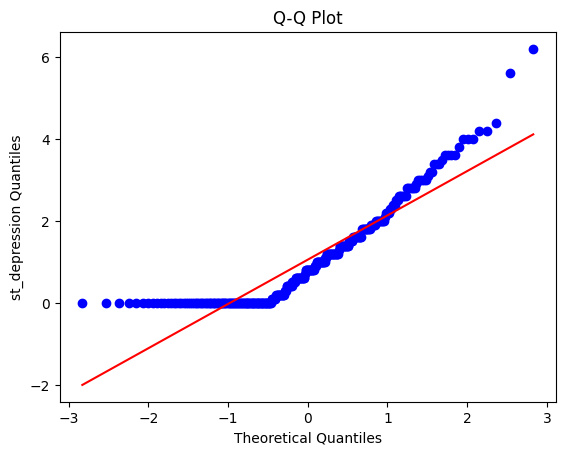

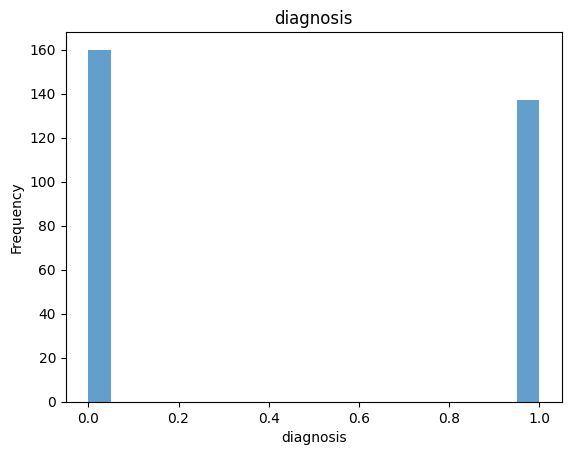

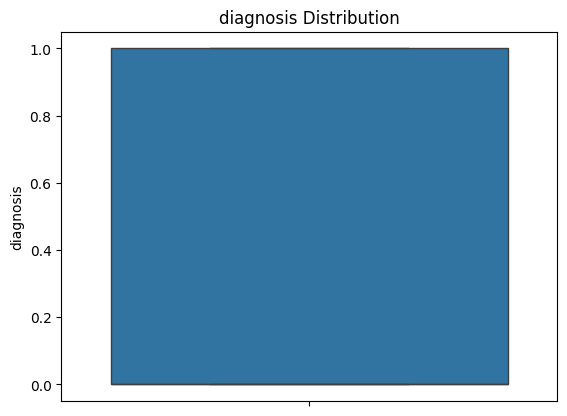

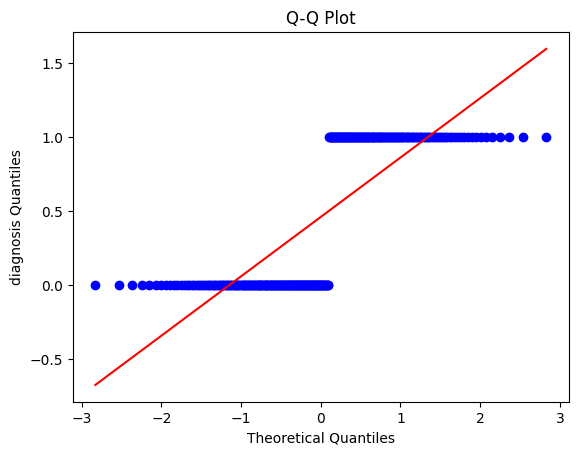

In [15]:
for column in data_numeric:

    data_numeric[column].describe()

    plt.hist(data_numeric[column], bins=20, alpha=0.7)

    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'{column}')
    plt.show()

    sns.boxplot(y= data[column], data=data)
    plt.title(f'{column} Distribution')
    plt.show()

    stats.probplot(data_numeric[column], plot=plt)
    plt.title('Q-Q Plot')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel(f'{column} Quantiles')
    plt.show()

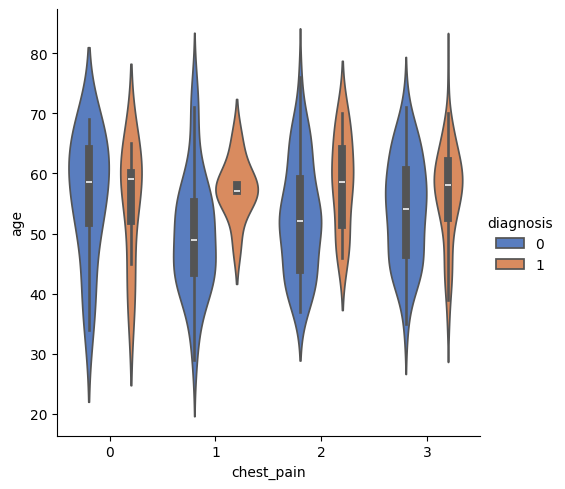

In [ ]:
violinplt = sns.catplot(x='chest_pain', y='age', hue='diagnosis', kind='violin', data=data, palette='muted')

plt.show()


We will now check for outliers in the numerical columns.

In [16]:
for column in data_numeric:
    Q1 = data_numeric[column].quantile(0.25)
    Q3 = data_numeric[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data_numeric[(data_numeric[column]< lower_bound) | (data_numeric[column] > upper_bound)]
    percentage_outliers = (len(outliers) / len(data_numeric[column])) * 100
    print (f"Column:{column}")
print(f"Number of outliers: {len(outliers)}")
print(f"Percentage of outliers: {percentage_outliers: .2f}%")
print("Outliers:")
print(outliers)
print("\n")


Column:age
Column:cholesterol
Column:max_hr
Column:st_depression
Column:diagnosis
Number of outliers: 0
Percentage of outliers:  0.00%
Outliers:
Empty DataFrame
Columns: [age, cholesterol, max_hr, st_depression, diagnosis]
Index: []




We will now implement one simple Perceptron with a single hidden layer trained with standard Backpropagation Algorithm:

In [17]:
from torch import nn
import torch.nn.functional as F

In [18]:
data.shape

(297, 14)

We will now split the data into training and testing


In [19]:
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.int64)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.int64)


We will now make the Perceptron Architecture


In [20]:
class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP, self).__init__()
    self.hidden = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.output = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = self.hidden(x)
    x = self.relu(x)
    x =  self.output(x)
    return x


We will now Initialize the Model

In [21]:
input_size = X_train.shape[1]
hidden_size = 10
output_size = 2
model = MLP(input_size, hidden_size, output_size)


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01)

Now we will train the Model

We will now change the epochs number.

In [23]:
import time

model.train()
epochs = 1000

 #Record the start time for the epochs training

start_time = time.time()

for epoch in range(epochs):


    # Forward pass
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)


    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Print progress
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


end_time = time.time()

training_time = end_time - start_time

print('Training time:', training_time)

# Evaluation on the test set
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    _, predicted_labels = torch.max(predictions, 1)

# Calculate accuracy
accuracy = accuracy_score(y_test.numpy(), predicted_labels.numpy())
print(f'Accuracy on the test set: {accuracy:.4f}')


Epoch [100/1000], Loss: 0.6906
Epoch [200/1000], Loss: 0.6906
Epoch [300/1000], Loss: 0.6906
Epoch [400/1000], Loss: 0.6906
Epoch [500/1000], Loss: 0.6906
Epoch [600/1000], Loss: 0.6906
Epoch [700/1000], Loss: 0.6906
Epoch [800/1000], Loss: 0.6906
Epoch [900/1000], Loss: 0.6906
Epoch [1000/1000], Loss: 0.6906
Training time: 0.7580258846282959
Accuracy on the test set: 0.5500


We will conduct a grid search on different values of hidden neurons and learning rates


In [24]:
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.5]
hidden_size = [1, 3, 5, 7, 8, 10]

accuracy_values = np.zeros((len(learning_rates), len(hidden_size)))
training_times = np.zeros((len(learning_rates), len(hidden_size)))



In [25]:


for i, lr in enumerate(learning_rates):
    for j, hs in enumerate(hidden_size):
        model = MLP(input_size, hs, output_size)  # Create a new model for each combination
        optimizer = optim.Adam(model.parameters(), lr=lr)  # Use the current learning rate

        model.train()

        epochs = 1000

        start_time = time.time()

        for epoch in range(epochs):
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

        end_time = time.time()
        training_time = end_time - start_time

        print('Training time:', training_time)

        model.eval()
        with torch.no_grad():
            predictions = model(X_test)
            _, predicted_labels = torch.max(predictions, 1)

        accuracy = accuracy_score(y_test.numpy(), predicted_labels.numpy())
        print(f'Accuracy on the test set: {accuracy:.4f}')

        accuracy_values[i, j] = accuracy
        training_times[i, j] = training_time

Epoch [100/1000], Loss: 0.6906
Epoch [200/1000], Loss: 0.6906
Epoch [300/1000], Loss: 0.6906
Epoch [400/1000], Loss: 0.6906
Epoch [500/1000], Loss: 0.6906
Epoch [600/1000], Loss: 0.6906
Epoch [700/1000], Loss: 0.6906
Epoch [800/1000], Loss: 0.6906
Epoch [900/1000], Loss: 0.6906
Epoch [1000/1000], Loss: 0.6906
Training time: 1.2755279541015625
Accuracy on the test set: 0.5500
Epoch [100/1000], Loss: 0.6981
Epoch [200/1000], Loss: 0.6906
Epoch [300/1000], Loss: 0.6906
Epoch [400/1000], Loss: 0.6906
Epoch [500/1000], Loss: 0.6906
Epoch [600/1000], Loss: 0.6906
Epoch [700/1000], Loss: 0.6906
Epoch [800/1000], Loss: 0.6906
Epoch [900/1000], Loss: 0.6906
Epoch [1000/1000], Loss: 0.6906
Training time: 1.3527705669403076
Accuracy on the test set: 0.5500
Epoch [100/1000], Loss: 0.6907
Epoch [200/1000], Loss: 0.6906
Epoch [300/1000], Loss: 0.6906
Epoch [400/1000], Loss: 0.6906
Epoch [500/1000], Loss: 0.6906
Epoch [600/1000], Loss: 0.6906
Epoch [700/1000], Loss: 0.6906
Epoch [800/1000], Loss: 0.6

Now we will plot the results

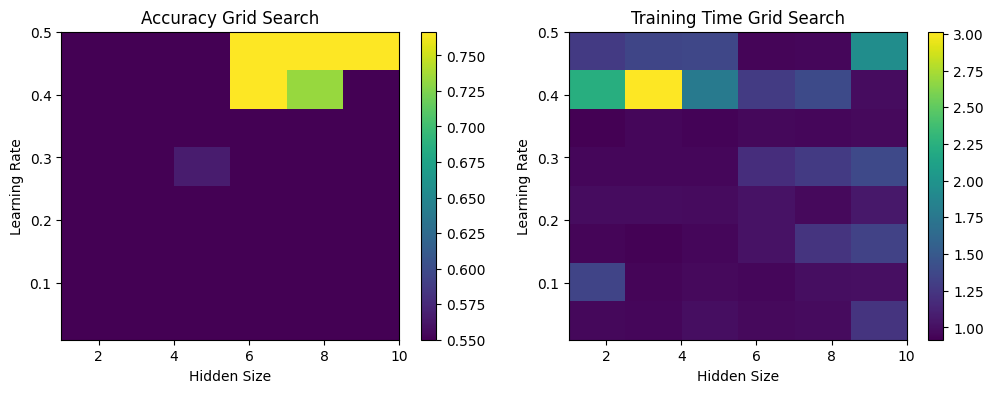

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
im = ax1.imshow(accuracy_values, cmap='viridis', aspect='auto', extent=[min(hidden_size), max(hidden_size), min(learning_rates), max(learning_rates)])
ax1.set_title('Accuracy Grid Search')
ax1.set_xlabel('Hidden Size')
ax1.set_ylabel('Learning Rate')
fig.colorbar(im, ax=ax1)

# Training time plot
im = ax2.imshow(training_times, cmap='viridis', aspect='auto', extent=[min(hidden_size), max(hidden_size), min(learning_rates), max(learning_rates)])
ax2.set_title('Training Time Grid Search')
ax2.set_xlabel('Hidden Size')
ax2.set_ylabel('Learning Rate')
fig.colorbar(im, ax=ax2)

plt.show()

We will now plot the best Values for training time and accuracy

In [27]:
max_accuracy_index = np.unravel_index(np.argmax(accuracy_values, axis=None), accuracy_values.shape)
min_time_index = np.unravel_index(np.argmin(training_times, axis=None), training_times.shape)
print(f'Highest accuracy: {accuracy_values[max_accuracy_index]:.4f} at LR={learning_rates[max_accuracy_index[0]]}, Hidden Size={hidden_size[max_accuracy_index[1]]}')
print(f'Lowest training time: {training_times[min_time_index]:.4f} at LR={learning_rates[min_time_index[0]]}, Hidden Size={hidden_size[min_time_index[1]]}')


Highest accuracy: 0.7667 at LR=0.01, Hidden Size=7
Lowest training time: 0.9162 at LR=0.1, Hidden Size=1


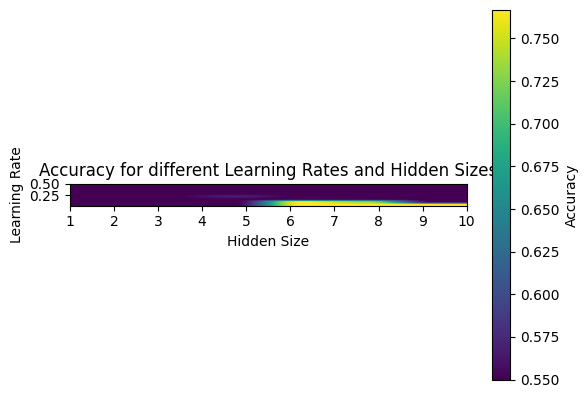

In [28]:
import matplotlib.pyplot as plt

plt.imshow(accuracy_values, cmap='viridis', origin='lower', extent=[min(hidden_size), max(hidden_size), min(learning_rates), max(learning_rates)])
plt.colorbar(label='Accuracy')
plt.xlabel('Hidden Size')
plt.ylabel('Learning Rate')
plt.title('Accuracy for different Learning Rates and Hidden Sizes')
plt.show()

We will now build the MLP witht he Sigmoid activation. We will use the same methods as above.


In [29]:
class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP, self).__init__()
    self.hidden = nn.Linear(input_size, hidden_size)
    self.sigmoid = nn.Sigmoid()
    self.output = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = self.hidden(x)
    x = self.sigmoid(x)
    x =  self.output(x)
    return x


In [30]:
input_size = X_train.shape[1]
hidden_size = 10
output_size = 2
model = MLP(input_size, hidden_size, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [31]:
model.train()
epochs = 1000
start_time = time.time()

for epoch in range(epochs):
    # Forward pass
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

end_time = time.time()
training_time = end_time - start_time

print('Training time:', training_time)

model.eval()
with torch.no_grad():
    predictions = model(X_test)
    _, predicted_labels = torch.max(predictions, 1)

# Calculate accuracy
accuracy = accuracy_score(y_test.numpy(), predicted_labels.numpy())
print(f'Accuracy on the test set: {accuracy:.4f}')


Epoch [100/1000], Loss: 0.6520
Epoch [200/1000], Loss: 0.6382
Epoch [300/1000], Loss: 0.6311
Epoch [400/1000], Loss: 0.6243
Epoch [500/1000], Loss: 0.6174
Epoch [600/1000], Loss: 0.6119
Epoch [700/1000], Loss: 0.6073
Epoch [800/1000], Loss: 0.6034
Epoch [900/1000], Loss: 0.6000
Epoch [1000/1000], Loss: 0.5971
Training time: 0.686486005783081
Accuracy on the test set: 0.6500


In [32]:
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.5]
hidden_sizes = [1, 3, 5, 7, 8, 10]

accuracy_values = np.zeros((len(learning_rates), len(hidden_sizes)))
training_times = np.zeros((len(learning_rates), len(hidden_sizes)))


In [33]:
for i, lr in enumerate(learning_rates):
    for j, hs in enumerate(hidden_sizes):
        model = MLP(input_size, hs, output_size)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        model.train()

        start_time = time.time()

        for epoch in range(epochs):
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

        end_time = time.time()
        training_time = end_time - start_time

        print('Training time:', training_time)

        model.eval()
        with torch.no_grad():
            predictions = model(X_test)
            _, predicted_labels = torch.max(predictions, 1)

        accuracy = accuracy_score(y_test.numpy(), predicted_labels.numpy())
        print(f'Accuracy on the test set: {accuracy:.4f}')

        accuracy_values[i, j] = accuracy
        training_times[i, j] = training_time

Epoch [100/1000], Loss: 0.6906
Epoch [200/1000], Loss: 0.6906
Epoch [300/1000], Loss: 0.6906
Epoch [400/1000], Loss: 0.6906
Epoch [500/1000], Loss: 0.6906
Epoch [600/1000], Loss: 0.6906
Epoch [700/1000], Loss: 0.6906
Epoch [800/1000], Loss: 0.6906
Epoch [900/1000], Loss: 0.6906
Epoch [1000/1000], Loss: 0.6906
Training time: 1.013735294342041
Accuracy on the test set: 0.5500
Epoch [100/1000], Loss: 0.6906
Epoch [200/1000], Loss: 0.6906
Epoch [300/1000], Loss: 0.6906
Epoch [400/1000], Loss: 0.6906
Epoch [500/1000], Loss: 0.6906
Epoch [600/1000], Loss: 0.6906
Epoch [700/1000], Loss: 0.6906
Epoch [800/1000], Loss: 0.6906
Epoch [900/1000], Loss: 0.6906
Epoch [1000/1000], Loss: 0.6906
Training time: 1.041940689086914
Accuracy on the test set: 0.5500
Epoch [100/1000], Loss: 0.5114
Epoch [200/1000], Loss: 0.3201
Epoch [300/1000], Loss: 0.2980
Epoch [400/1000], Loss: 0.2917
Epoch [500/1000], Loss: 0.2875
Epoch [600/1000], Loss: 0.2845
Epoch [700/1000], Loss: 0.2822
Epoch [800/1000], Loss: 0.280

In [42]:
max_accuracy_index = np.unravel_index(np.argmax(accuracy_values), accuracy_values.shape)
min_time_index = np.unravel_index(np.argmin(training_times), training_times.shape)

# Extract corresponding values
best_accuracy = accuracy_values[max_accuracy_index]
best_time = training_times[min_time_index]

TypeError: 'int' object is not subscriptable

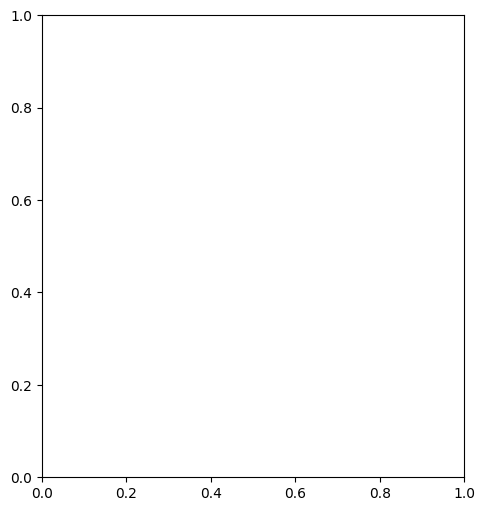

In [43]:
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(learning_rates, accuracy_values[max_accuracy_index[0], :], label=f'Hidden Size: {hidden_size[max_accuracy_index[1]]}')  #
plt.scatter(learning_rates[max_accuracy_index[0]], best_accuracy, color='red')
plt.title('Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training Time
plt.subplot(1, 2, 2)
plt.plot(learning_rates, training_times[min_time_index[0], :], label=f'Hidden Size: {hidden_size[min_time_index[1]]}')
plt.scatter(learning_rates[min_time_index[0]], best_time, color='red')
plt.title('Training Time vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Training Time (s)')
plt.legend()

plt.tight_layout()
plt.show()